# **Save the Earth from another Carrington Event**
*Team RoboTO* - NASA International Space Apps Challenge

The following code has been implemented for data pre-processing of provided dataset, making it suitable to be used by a Machine Learning algorithm.

In [ ]:
# install and import necessary tools

!pip install cdflib
!pip install spacepy
!pip install matplotlib
!pip install numpy
!pip install wget
!pip install dtaidistance

import cdflib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import spacepy
import math
import string
import wget

In [ ]:
########################## GET URL OF DATASETS ##########################

months_of_non_leap_year = ["31", "28", "31", "30", "31", "30", "31", "31", "30", "31", "30", "31"]
months_of_leap_year = ["31", "29", "31", "30", "31", "30", "31", "31", "30", "31", "30", "31"]

# dscovr datasets url strings
dscovr_datasets_url_strings_train = []
dscovr_datasets_url_strings_test = []
wind_datasets_url_strings_train = []
wind_datasets_url_strings_test = []
dd = "03"
mm = "06"
yy = "2016"
version = "02"

while True:
  # get next url
  dscovr_url = "https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h1/faraday_cup/" + yy + "/dscovr_h1_fc_" + yy + mm + dd + "_v" + version + ".cdf"
  wind_url = "https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/" + yy + "/wi_h1_swe_" + yy + mm + dd + "_v01.cdf"

  # print the date relative to the considered data
  print(yy + "-" + mm + "-" + dd)

  # skip empty files
  if not ((yy == "2017" and mm == "03" and dd == "21") or (yy == "2017" and mm == "03" and dd == "27") \
  or (yy == "2017" and mm == "06" and dd == "18") or (yy == "2017" and mm == "06" and dd == "30") or (yy == "2017" and mm == "07" and dd == "30") \
  or (yy == "2017" and mm == "07" and dd == "31") or (yy == "2017" and mm == "08" and dd == "18") or (yy == "2017" and mm == "11" and dd == "30") \
  or (yy == "2018" and mm == "01" and dd == "04") or (yy == "2018" and mm == "01" and dd == "13") or (yy == "2018" and mm == "02" and dd == "14") \
  or (yy == "2018" and mm == "06" and dd == "28") or (yy == "2019" and mm == "03" and dd == "03") or (yy == "2019" and mm == "03" and dd == "04") \
  or (yy == "2019" and mm == "03" and dd == "06") or (yy == "2019" and mm == "03" and dd == "07")):
    # append new URL
    if yy == "2019":
      dscovr_datasets_url_strings_test.append(dscovr_url)
      wind_datasets_url_strings_test.append(wind_url)
    else:
      dscovr_datasets_url_strings_train.append(dscovr_url)
      wind_datasets_url_strings_train.append(wind_url)

  if yy == "2019" and mm == "06" and dd == "27":
    break
  
  # change version of dataset
  if yy == "2016" and mm == "06" and dd == "03":
    version = "06"
  elif yy == "2017" and mm == "08" and dd == "31":
    version = "07"
  elif yy == "2017" and mm == "12" and dd == "31":
    version = "08"
  elif yy == "2018" and mm == "06" and dd == "08":
    version = "09"
  elif yy == "2018" and mm == "08" and dd == "18":
    version = "10"
  elif yy == "2018" and mm == "09" and dd == "15":
    version = "11"
  elif yy == "2018" and mm == "12" and dd == "01":
    version = "12"
  elif yy == "2019" and mm == "02" and dd == "09":
    version = "13"
  elif yy == "2019" and mm == "03" and dd == "01":
    version = "14"

  # check if there's a leap year or not
  if yy == "2016":
    month_vect = months_of_leap_year
  else:
    month_vect = months_of_non_leap_year

  # change day, month, year
  dd = str(int(dd) + 1)
  if (int(dd) > int(month_vect[int(mm)-1])):
    dd = "1"
    if int(mm) < 9:
      mm = "0" + str(int(mm)+1)
    else:
      mm = str(int(mm)+1)

  if int(dd) < 10:
    dd = "0" + dd

  if mm > "12":
    yy = str(int(yy)+1)
    mm = "01"

dscovr_datasets_url_strings_train = np.asarray(dscovr_datasets_url_strings_train)
dscovr_datasets_url_strings_test = np.asarray(dscovr_datasets_url_strings_test)
wind_datasets_url_strings_train = np.asarray(wind_datasets_url_strings_train)
wind_datasets_url_strings_test = np.asarray(wind_datasets_url_strings_test)

In [ ]:
########################## MAIN DATA PARSING LOOP ##########################
data_matrix_train = np.empty([0, 6])
data_matrix_test = np.empty([0, 6])

for file_idx in range(0, dscovr_datasets_url_strings_train.size + dscovr_datasets_url_strings_test.size):

  # download data files
  if file_idx < dscovr_datasets_url_strings_train.size:
    dscovr_swe_name = wget.download(dscovr_datasets_url_strings_train[file_idx])
    wind_swe_name = wget.download(wind_datasets_url_strings_train[file_idx])
  else:
    dscovr_swe_name = wget.download(dscovr_datasets_url_strings_test[file_idx - dscovr_datasets_url_strings_train.size])
    wind_swe_name = wget.download(wind_datasets_url_strings_test[file_idx - dscovr_datasets_url_strings_train.size])

  dscovr_swe = cdflib.cdf_to_xarray(dscovr_swe_name, to_unixtime=False, fillval_to_nan=True)
  wind_swe = cdflib.cdf_to_xarray(wind_swe_name, to_unixtime=False, fillval_to_nan=True)


  ########################## TIME ##########################

  # dscovr time data process
  dscovr_swe_time = dscovr_swe["Time_PB5"].to_numpy()

  rowD, colD = dscovr_swe_time.shape

  dscovr_swe_time_year = np.empty([rowD, 1], dtype='int')
  dscovr_swe_time_day = np.empty([rowD, 1], dtype='int')
  dscovr_swe_time_ms = np.empty([rowD, 1], dtype='int')

  for i in range(0, rowD):
    dscovr_swe_time_year[i] = dscovr_swe_time[i][0]
    dscovr_swe_time_day[i] = dscovr_swe_time[i][1]
    dscovr_swe_time_ms[i] = dscovr_swe_time[i][2]

  dscovr_swe_time_year = np.reshape(dscovr_swe_time_year, dscovr_swe_time_year.size)
  dscovr_swe_time_day = np.reshape(dscovr_swe_time_day, dscovr_swe_time_day.size)
  dscovr_swe_time_ms = np.reshape(dscovr_swe_time_ms, dscovr_swe_time_ms.size)


  # wind time data process
  wind_swe_time_epochs = wind_swe["Epoch"].to_numpy()

  rowW = wind_swe_time_epochs.size

  wind_swe_time_year = np.empty([wind_swe_time_epochs.size, 1], dtype='int')
  wind_swe_time_day = np.empty([wind_swe_time_epochs.size, 1], dtype='int')
  wind_swe_time_ms = np.empty([wind_swe_time_epochs.size, 1], dtype='int')
  for i in range(0, wind_swe_time_epochs.size):
    wind_swe_time_year[i] = cdflib.cdfepoch.to_datetime(wind_swe_time_epochs[i])[0].year
    wind_swe_time_day[i] = int(cdflib.cdfepoch.to_datetime(wind_swe_time_epochs[i])[0].strftime("%j"))
    hh = cdflib.cdfepoch.to_datetime(wind_swe_time_epochs[i])[0].hour
    mm = cdflib.cdfepoch.to_datetime(wind_swe_time_epochs[i])[0].minute
    ss = cdflib.cdfepoch.to_datetime(wind_swe_time_epochs[i])[0].second
    micros = cdflib.cdfepoch.to_datetime(wind_swe_time_epochs[i])[0].microsecond
    wind_swe_time_ms[i] = int(micros/1000) + int(ss*1000) + int(mm*1000*60) + int(hh*1000*60*60)

  wind_swe_time_year = np.reshape(wind_swe_time_year, wind_swe_time_year.size)
  wind_swe_time_day = np.reshape(wind_swe_time_day, wind_swe_time_day.size)
  wind_swe_time_ms = np.reshape(wind_swe_time_ms, wind_swe_time_ms.size)



  ########################## PROTONS VELOCITY ##########################

  # dscovr proton data process
  dscovr_swe_proton_vel_vect = dscovr_swe['V_GSE'].to_numpy()

  rowD, colD = dscovr_swe_time.shape

  dscovr_swe_proton_vel_mag = np.empty([rowD, 1])

  for i in range(0, rowD):
    if np.isnan(dscovr_swe_proton_vel_vect[i][0]) or np.isnan(dscovr_swe_proton_vel_vect[i][1]) or np.isnan(dscovr_swe_proton_vel_vect[i][2]):
      dscovr_swe_proton_vel_mag[i] = math.nan
      continue
    x = dscovr_swe_proton_vel_vect[i][0]
    y = dscovr_swe_proton_vel_vect[i][1]
    z = dscovr_swe_proton_vel_vect[i][2]
    dscovr_swe_proton_vel_mag[i] = math.sqrt(math.pow(x,2) + math.pow(y,2) + math.pow(z,2))

  dscovr_swe_proton_vel_mag = np.reshape(dscovr_swe_proton_vel_mag, dscovr_swe_proton_vel_mag.size)

  # wind proton data process
  wind_swe_proton_vel_mag = wind_swe['Proton_V_nonlin'].to_numpy()

  wind_swe_proton_vel_mag = np.reshape(wind_swe_proton_vel_mag, wind_swe_proton_vel_mag.size)



  ########################## PROTONS THERMAL SPEED AND NUMBER DENSITY ##########################

  # dscovr proton thermal data process
  dscovr_swe_proton_therm = dscovr_swe['THERMAL_SPD'].to_numpy()
  dscovr_swe_proton_num_dens = dscovr_swe['Np'].to_numpy()

  dscovr_swe_proton_therm = np.reshape(dscovr_swe_proton_therm, dscovr_swe_proton_therm.size)
  dscovr_swe_proton_num_dens = np.reshape(dscovr_swe_proton_num_dens, dscovr_swe_proton_num_dens.size)

  # wind proton data process
  wind_swe_proton_therm = wind_swe['Proton_W_nonlin'].to_numpy()
  wind_swe_proton_num_dens = wind_swe['Proton_Np_nonlin'].to_numpy()

  wind_swe_proton_therm = np.reshape(wind_swe_proton_therm, wind_swe_proton_therm.size)
  wind_swe_proton_num_dens = np.reshape(wind_swe_proton_num_dens, wind_swe_proton_num_dens.size)



  ########################## RE-ALIGN DSCOVR PROTON VELOCITY DATA BASED ON WIND MILLISECONDS SAMPLES ##########################

  dscovr_swe_proton_vel_mag_mapped = []
  
  for i in range(0, wind_swe_time_ms.size):
    # find nearest value of millisecond
    wind_ms = wind_swe_time_ms[i]
    difference_ms = np.absolute(dscovr_swe_time_ms - wind_ms)
    idx = difference_ms.argmin()
    if idx == 0 and wind_ms < dscovr_swe_time_ms[idx]:
      dscovr_swe_proton_vel_mag_mapped.append(dscovr_swe_proton_vel_mag[idx])
      continue
    if idx == dscovr_swe_proton_vel_mag.size-1 and dscovr_swe_time_ms[idx] < wind_ms:
      dscovr_swe_proton_vel_mag_mapped.append(dscovr_swe_proton_vel_mag[idx])
      continue
    
    # if we are not in at the extremes, then...
    if dscovr_swe_proton_vel_mag[idx] <= wind_ms:
      lb = idx
      ub = idx+1
    else:
      lb = idx-1
      ub = idx
    
    # avoid indexing out of bound
    if ub >= dscovr_swe_proton_vel_mag.size-1:
      ub = dscovr_swe_proton_vel_mag.size-1

    if np.isnan(dscovr_swe_proton_vel_mag[lb]):
      dscovr_swe_proton_vel_mag_mapped.append(dscovr_swe_proton_vel_mag[ub])
    elif np.isnan(dscovr_swe_proton_vel_mag[ub]):
      dscovr_swe_proton_vel_mag_mapped.append(dscovr_swe_proton_vel_mag[lb])
    else:
      dscovr_swe_proton_vel_mag_mapped.append((dscovr_swe_proton_vel_mag[lb]+dscovr_swe_proton_vel_mag[ub])/2)

  dscovr_swe_proton_vel_mag_mapped = np.asarray(dscovr_swe_proton_vel_mag_mapped)



  ########################## RE-ALIGN DSCOVR PROTON THERMAL SPEED DATA BASED ON WIND MILLISECONDS SAMPLES ##########################

  pad_value = 100000

  dscovr_swe_proton_therm_mapped = []

  for i in range(0, wind_swe_time_ms.size):
    # find nearest value of millisecond
    wind_ms = wind_swe_time_ms[i]
    difference_ms = np.absolute(dscovr_swe_time_ms - wind_ms)
    idx = difference_ms.argmin()
    if idx == 0 and wind_ms < dscovr_swe_time_ms[idx]:
      dscovr_swe_proton_therm_mapped.append(dscovr_swe_proton_therm[idx])
      continue
    if idx == dscovr_swe_proton_therm.size-1 and dscovr_swe_time_ms[idx] < wind_ms:
      dscovr_swe_proton_therm_mapped.append(dscovr_swe_proton_therm[idx])
      continue
    
    # if we are not in at the extremes, then...
    if dscovr_swe_proton_therm[idx] <= wind_ms:
      lb = idx
      ub = idx+1
    else:
      lb = idx-1
      ub = idx
    
    # avoid indexing out of bound
    if ub >= dscovr_swe_proton_therm.size-1:
      ub = dscovr_swe_proton_therm.size-1

    if np.isnan(dscovr_swe_proton_therm[lb]) or dscovr_swe_proton_therm[lb] >= pad_value*0.8:
      dscovr_swe_proton_therm_mapped.append(dscovr_swe_proton_therm[ub])
    elif np.isnan(dscovr_swe_proton_therm[ub]) or dscovr_swe_proton_therm[lb] >= pad_value*0.8:
      dscovr_swe_proton_therm_mapped.append(dscovr_swe_proton_therm[lb])
    else:
      dscovr_swe_proton_therm_mapped.append((dscovr_swe_proton_therm[lb]+dscovr_swe_proton_therm[ub])/2)

  dscovr_swe_proton_therm_mapped = np.asarray(dscovr_swe_proton_therm_mapped)




  ########################## RE-ALIGN DSCOVR DENSITY DATA BASED ON WIND MILLISECONDS SAMPLES ##########################

  dscovr_swe_proton_num_dens_mapped = []

  for i in range(0, wind_swe_time_ms.size):
    # find nearest value of millisecond
    wind_ms = wind_swe_time_ms[i]
    difference_ms = np.absolute(dscovr_swe_time_ms - wind_ms)
    idx = difference_ms.argmin()
    if idx == 0 and wind_ms < dscovr_swe_time_ms[idx]:
      dscovr_swe_proton_num_dens_mapped.append(dscovr_swe_proton_num_dens[idx])
      continue
    if idx == dscovr_swe_proton_num_dens.size-1 and dscovr_swe_time_ms[idx] < wind_ms:
      dscovr_swe_proton_num_dens_mapped.append(dscovr_swe_proton_num_dens[idx])
      continue
    
    # if we are not in at the extremes, then...
    if dscovr_swe_proton_num_dens[idx] <= wind_ms:
      lb = idx
      ub = idx+1
    else:
      lb = idx-1
      ub = idx
    
    # avoid indexing out of bound
    if ub >= dscovr_swe_proton_num_dens.size-1:
      ub = dscovr_swe_proton_num_dens.size-1

    if np.isnan(dscovr_swe_proton_num_dens[lb]):
      dscovr_swe_proton_num_dens_mapped.append(dscovr_swe_proton_num_dens[ub])
    elif np.isnan(dscovr_swe_proton_num_dens[ub]):
      dscovr_swe_proton_num_dens_mapped.append(dscovr_swe_proton_num_dens[lb])
    else:
      dscovr_swe_proton_num_dens_mapped.append((dscovr_swe_proton_num_dens[lb]+dscovr_swe_proton_num_dens[ub])/2)

  dscovr_swe_proton_num_dens_mapped = np.asarray(dscovr_swe_proton_num_dens_mapped)
    


  ########################## CLEAN DSCOVR AND WIND DATA FROM NaN AND PAD-VALUES ##########################

  i = 0
  size = wind_swe_time_ms.size

  while i < size:
    if np.isnan(dscovr_swe_proton_vel_mag_mapped[i]) or np.isnan(wind_swe_proton_vel_mag[i]) \
    or np.isnan(dscovr_swe_proton_therm_mapped[i]) or dscovr_swe_proton_therm_mapped[i] >= pad_value*0.8 or np.isnan(wind_swe_proton_therm[i]) or wind_swe_proton_therm[i] >= pad_value*0.8 \
    or np.isnan(dscovr_swe_proton_num_dens_mapped[i]) or np.isnan(wind_swe_proton_num_dens[i]):

      dscovr_swe_proton_vel_mag_mapped = np.delete(dscovr_swe_proton_vel_mag_mapped, i, 0)
      dscovr_swe_proton_therm_mapped = np.delete(dscovr_swe_proton_therm_mapped, i, 0)
      dscovr_swe_proton_num_dens_mapped = np.delete(dscovr_swe_proton_num_dens_mapped, i, 0)
      wind_swe_proton_vel_mag = np.delete(wind_swe_proton_vel_mag, i, 0)
      wind_swe_proton_therm = np.delete(wind_swe_proton_therm, i, 0)
      wind_swe_proton_num_dens = np.delete(wind_swe_proton_num_dens, i, 0)
      wind_swe_time_ms = np.delete(wind_swe_time_ms, i, 0)
      size = size - 1
    else:
      i = i + 1


  ########################## BUILD MATRIX OF WIND AND DSCOVR DATA FOR GIVEN FILE ##########################

  data_matrix = np.concatenate((wind_swe_proton_vel_mag.reshape(-1,1), wind_swe_proton_num_dens.reshape(-1,1), wind_swe_proton_therm.reshape(-1,1), \
                              dscovr_swe_proton_vel_mag_mapped.reshape(-1,1), dscovr_swe_proton_num_dens_mapped.reshape(-1,1), dscovr_swe_proton_therm_mapped.reshape(-1,1)), axis=1)

  if "2019" not in dscovr_swe_name:
    data_matrix_train = np.concatenate((data_matrix_train, data_matrix), axis=0)
  else:
    data_matrix_test = np.concatenate((data_matrix_test, data_matrix), axis=0)

  # print files already processed
  print(dscovr_swe_name + " file processed")
  print(wind_swe_name + " file processed")


########################## BUILD FINAL MATRICES OF WIND AND DSCOVR DATA ##########################
np.savetxt("data_matrix_train.csv", data_matrix_train, delimiter=",")
np.savetxt("data_matrix_test.csv", data_matrix_test, delimiter=",")


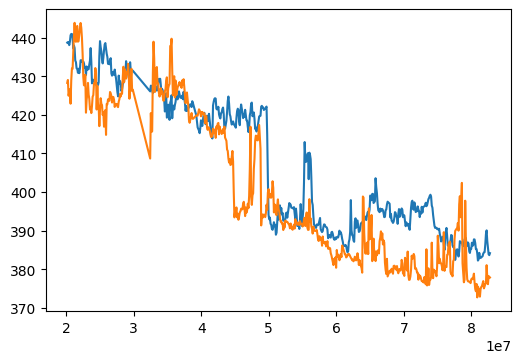

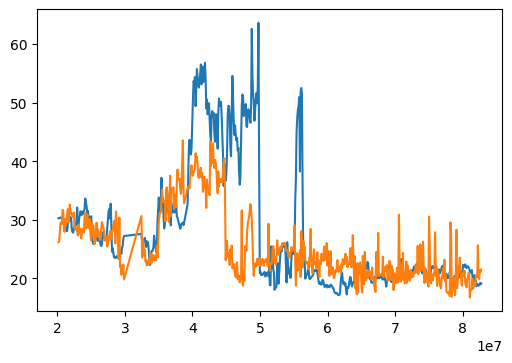

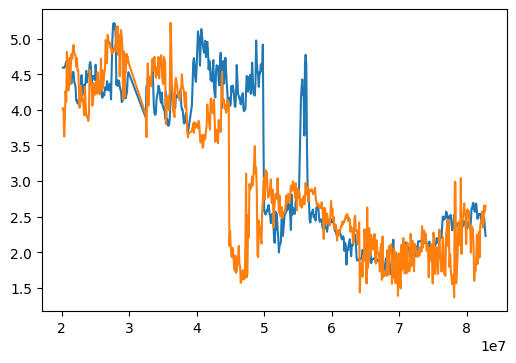

In [ ]:
########################## DATA PLOTS ##########################

tspan_wind = np.arange(0, wind_swe_time_ms.size)

plt.figure(dpi=100)
plt.plot(wind_swe_time_ms, dscovr_swe_proton_vel_mag_mapped)
plt.plot(wind_swe_time_ms, wind_swe_proton_vel_mag)
plt.show()

plt.figure(dpi=100)
plt.plot(wind_swe_time_ms, dscovr_swe_proton_therm_mapped)
plt.plot(wind_swe_time_ms, wind_swe_proton_therm)
plt.show()

plt.figure(dpi=100)
plt.plot(wind_swe_time_ms, dscovr_swe_proton_num_dens_mapped)
plt.plot(wind_swe_time_ms, wind_swe_proton_num_dens)
plt.show()

In [ ]:
########################## DYNAMIC TIME WARPING PLOTS OF DATA ##########################
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

dscovr_proton_vel_mag = np.array(dscovr_swe_proton_vel_mag_mapped)
wind_proton_vel_mag = np.array(wind_swe_proton_vel_mag)

dscovr_proton_therm = np.array(dscovr_swe_proton_therm_mapped)
wind_proton_therm = np.array(wind_swe_proton_therm)

dscovr_proton_num_dens = np.array(dscovr_swe_proton_num_dens_mapped)
wind_proton_num_dens = np.array(wind_swe_proton_num_dens)

path_1 = dtw.warping_path(dscovr_proton_vel_mag, wind_proton_vel_mag)
path_2 = dtw.warping_path(dscovr_proton_therm, wind_proton_therm)
path_3 = dtw.warping_path(dscovr_proton_num_dens, wind_proton_num_dens)

plt.figure(dpi=1200)
dtwvis.plot_warping(dscovr_proton_vel_mag, wind_proton_vel_mag, path_1, filename="_plot_1_dyn_time_warp.png")
plt.figure(dpi=1200)
dtwvis.plot_warping(dscovr_proton_therm, wind_proton_therm, path_2, filename="_plot_2_dyn_time_warp.png")
plt.figure(dpi=1200)
dtwvis.plot_warping(dscovr_proton_num_dens, wind_proton_num_dens, path_3, filename="_plot_3_dyn_time_warp.png")

(None, None)

<Figure size 7200x4800 with 0 Axes>

<Figure size 7200x4800 with 0 Axes>

<Figure size 7200x4800 with 0 Axes>